In [9]:
%cd drive/MyDrive/thesis
%ls

[Errno 2] No such file or directory: 'drive/MyDrive/thesis'
/content/drive/MyDrive/thesis
cc.zh.300.bin                                  wen_wuu_sent_alignment.csv
cmn_wen_sent_alignment.csv                     wen_yue_sent_alignment.csv
cmn_wen_subs.csv                               wen_yue_subs.csv
cmn_wuu_sent_alignment.csv                     wuu_wen_bigram.csv
cmn_wuu_subs.csv                               wuu_wen_sent_alignment.csv
cmn_yue_sent_alignment.csv                     wuu_wen_subs.csv
cmn_yue_subs.csv                               wuu_wen_trigram.csv
cmn-yue-wuu-wen-parallel-simplified.csv        wuu_wen_unigram.csv
cmn-yue-wuu-wen-parallel-simplified_final.csv  wuu_yue_sent_alignment.csv
sgns.merge.char                                wuu_yue_subs.csv


In [10]:
from difflib import ndiff
import pandas as pd
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
from statistics import stdev, mean, median
import seaborn as sns

In [11]:
a = "这个苹果很酸"
b = "搿只苹果老酸个"

In [12]:
for d in ndiff(a, b):
  print(d[0], d[2])

- 这
- 个
+ 搿
+ 只
  苹
  果
- 很
+ 老
  酸
+ 个


In [13]:
from numpy import delete
# the class to caculate the edit distance, takes two strings as arguments
# return edit distances, edit detailed (deletion, addition and substitution and remain)
# and edit details for the strings (what strings got deleted, added or substituded )
# the normalized distance get is the opposite of similarity

class edit_distance():
  def __init__(self, str1, str2):
    self.each_edit_details = [(s[0], s[2]) for s in ndiff(str1, str2)]
    self.strings_len = len(str1)+len(str2)

  def get_distance(self):
    # get normalized distance of two strings(divided by the total length of two strings)
    edit = {"+":0, "-":0}
    distance = 0
    for edit_code, *_ in self.each_edit_details:
        #if edit_code == " ": # same character, so no edits
            #distance += edit["+"] + edit["-"]
            #edit["+"] = 0
            #edit["-"] = 0
        if edit_code == "+" or edit_code == "-": 
            edit[edit_code] += 1
    distance += edit["+"]+edit["-"]
    return distance/self.strings_len  
  
  def get_each_edit(self):
    edits = self.each_edit_details
    subs, delete, add, noedit = [], [], [], []
    pending_minus, pending_plus = {}, {}
    i = 0
    while i < len(edits):
      current = edits[i]
      #print("current:", i, current)
      if current[0] == "-":
        minus, plus = [], []
        if i == len(edits)-1:
          i += 1
        j = i
        while j < len(edits)-1:
          j += 1
          next = edits[j]
          if next[0] == " ":
            i = j
            break
          else:
            if next[0] == "+":
              plus.append(next)
              i = j + 1
            if len(plus)==0 and next[0] == "-":
              minus.append(next)
              i = j + 1
            if len(plus)!=0 and next[0] == "-": # then it's "-" for next substring of substitution
              i = j
              break
        if len(plus)==0:  # all "-" before " ", 
          #add to pending because it can be substituted with all "+" substring later
          if "-" not in pending_minus:
            pending_minus["-"] = []
          all_minus_str = current[1] + "".join([m[1] for m in minus])
          pending_minus["-"].append("".join(all_minus_str)) 
        else:
          minus_str = current[1] + "".join([m[1] for m in minus])
          plus_str  = "".join([p[1] for p in plus])
          subs.append((minus_str, plus_str))
          
      elif current[0] == "+":
        minus, plus = [], []
        if i == len(edits)-1:
          i += 1
        j = i
        while j < len(edits)-1:
          j += 1
          next = edits[j]
          if next[0] == " ":
            i = j
            break
          else:
            if next[0] == "-":
              i = j + 1
              minus.append(next)
            if len(minus)==0 and next[0] == "+":
              plus.append(next)
              i = j + 1
            if len(minus)!=0 and next[0] == "+":
              i = j
              break
          #i = j+1
        if len(minus)==0:  # all "+" strings before " "
          #add to pending because it can be substituted with all "-" substring later
          if "+" not in pending_plus:
            pending_plus["+"] = []
          all_plus_str = current[1] + "".join([p[1] for p in plus])
          pending_plus["+"].append("".join(all_plus_str))
        else:
          minus_str = "".join([m[1] for m in minus])
          plus_str  = current[1] + "".join([p[1] for p in plus])
          subs.append((minus_str, plus_str))

      else:
        noedit.append(current[1])
        i += 1

    if ("-" not in pending_minus or len(pending_minus["-"]) == 0) and "+" in pending_plus:
      add += pending_plus["+"]
    elif ("+" not in pending_plus or len(pending_plus["+"]) == 0) and "-" in pending_minus:
      delete += pending_minus["-"]
    elif "+" in pending_plus and "-" in pending_minus:
      m, p = pending_minus["-"], pending_plus["+"]
      left = 0
      if len(m) > len(p):          
        for i in range(len(p)):
          minus_str = m[i]
          plus_str = p[i]
          subs.append((minus_str, plus_str))  
        left = len(m) - len(p) 
        delete += m[-left:] 
      else: # len(m) <= len(p)     
        for i in range(len(m)):
          minus_str = m[i]
          plus_str = p[i]
          subs.append((minus_str, plus_str)) 
        left = len(p) - len(m)
        add += p[-left:] 
  
    return {"deletion":delete, "addition": add, "substitution":subs, "noedit":noedit}
  


In [14]:
c = "你应该先和你的父母谈谈"
d = "侬应该跟㑚爷娘谈清爽先"

In [15]:
#!pip install textdistance
#import textdistance as td
#td.levenshtein(c, d)

In [16]:
edit = edit_distance(a, b)
edit.get_distance(), edit.each_edit_details

(0.5384615384615384,
 [('-', '这'),
  ('-', '个'),
  ('+', '搿'),
  ('+', '只'),
  (' ', '苹'),
  (' ', '果'),
  ('-', '很'),
  ('+', '老'),
  (' ', '酸'),
  ('+', '个')])

In [17]:
edit.get_each_edit()

{'deletion': [],
 'addition': ['个'],
 'substitution': [('这个', '搿只'), ('很', '老')],
 'noedit': ['苹', '果', '酸']}

#### Get all the data and start analysis

In [18]:
data_all = pd.read_csv("cmn-yue-wuu-wen-parallel-simplified_final.csv", encoding="utf-8")
data_all

,Unnamed: 0,cmn_id,cmn_sentence,wuu_sentence,wen_sentence,yue_sentence
0,0,1,我们试试看！,阿拉试试！,卬你试试眙！,我哋试吓吖！
1,1,51,那又怎样?,哏末哪能呢？,那就訾那能爻？,嗯，咁呢？
2,2,339240,不要说废话！,侬勿要瞎讲！,覅讲废话！,唔好喺度乱噏廿四！
3,3,340093,这个苹果很酸。,搿只苹果老酸个。,居个苹果酸显酸。,呢粒苹果好酸。
4,4,342196,别忘了明天六时来接我。,勿要忘记脱明朝6点钟来寻我。,覅悗记爻明朝六点钟走来接我。,唔好唔记得听日六点嚟搵我喎。
...,...,...,...,...,...,...
135,135,5500559,你们比我还高。,侬比我高。,你厘比我还高哩。,你高过我。
136,136,6559017,你好吗？,侬好伐？,你好啊伐？,你点呀？
137,137,10329955,你们怎么就是没相信我呢？,侬为啥勿相信我？,你厘訾那就冇相信我呢？,你点解唔信我呀？
138,138,10631557,他父母对他怀有过高的期望。,伊拉爷娘对伊期望过高。,渠个爸妈对渠期望忒高。,佢阿爸阿妈对佢期望过高。


In [19]:
### punctuations and numbers are removed
### save is only for saving the substitutions
### language names are "cmn", "wuu", "yue", "wen", 4 options
def get_all_distances(lang1_name, lang2_name, save=True):
  lang1 = data_all[lang1_name+"_sentence"]
  lang2 = data_all[lang2_name+"_sentence"]
  all_subs = []
  sentence_edits = {}
  punc = ["。", "，", "！", "？", "'", "\"", ",", ".", "、", "?", "「", "」"]
  for i in range(len(lang1)):
    #print(i, lang1[i], lang2[i])
    str1 = "".join([t.strip() for t in lang1[i] if t not in punc])
    str2 = "".join([t.strip() for t in lang2[i] if t not in punc])
    edit = edit_distance(str1, str2)
    each_edit = edit.get_each_edit()
    if save:
      all_subs += each_edit["substitution"]
    sentence_edits[i] = {"sent1":str1, "sent2":str2, "distance":edit.get_distance(), "each_edit":each_edit, "edit_details":edit.each_edit_details}
  if len(all_subs) > 0:
    all_subs = Counter(all_subs)
    all_subs = [(k[0], k[1], all_subs[k]) for k in all_subs.keys()]
    df = pd.DataFrame(data=all_subs, columns=[lang1_name, lang2_name, "count"])
    df.to_csv(lang1_name+"_"+lang2_name+"_subs.csv", encoding="utf-8")
  return sentence_edits

In [20]:
###get sum, largest and average of the edit distance of two languages
def distance_analytical(sentence_edits):
  sum, average, largest = 0, 0, 0
  largest_sents = 0
  all_distances = []
  all_del, all_add = [], []
  all_subs, all_same = [], []
  for i, edit in enumerate(sentence_edits):
    distance = sentence_edits[i]["distance"]
    each_edit = sentence_edits[i]["each_edit"]
    edit_details = sentence_edits[i]["edit_details"]

    sum += distance
    if distance > largest:
      largest = distance
      largest_sents = {i:(sentence_edits[i]["sent1"], sentence_edits[i]["sent2"])}
    
    all_distances.append(distance)

    deletion = each_edit["deletion"]
    add      = each_edit["addition"]
    subs     = each_edit["substitution"]
    same     = each_edit["noedit"]
    all_del += deletion
    all_add += add
    all_subs += subs
    all_same += same

  average = sum / len(sentence_edits)
  edit_details = {"all_del":all_del, "all_add":all_add,"all_subs":all_subs, "all_noEdits":all_same}
  return {"all_distances": all_distances,"distance_sum":sum, "distance_largest":(largest, largest_sents), "distance_average":average, "each_edit_details": edit_details}

##### Mandarin and Shanghainese

In [21]:
cmn_wuu = get_all_distances("cmn", "wuu")
cmn_wuu[3]

{'sent1': '这个苹果很酸',
 'sent2': '搿只苹果老酸个',
 'distance': 0.5384615384615384,
 'each_edit': {'deletion': [],
  'addition': ['个'],
  'substitution': [('这个', '搿只'), ('很', '老')],
  'noedit': ['苹', '果', '酸']},
 'edit_details': [('-', '这'),
  ('-', '个'),
  ('+', '搿'),
  ('+', '只'),
  (' ', '苹'),
  (' ', '果'),
  ('-', '很'),
  ('+', '老'),
  (' ', '酸'),
  ('+', '个')]}

In [22]:
cmn_wuu_distance = distance_analytical(cmn_wuu)
distances = cmn_wuu_distance["all_distances"]
sum = cmn_wuu_distance["distance_sum"]
largest = cmn_wuu_distance["distance_largest"]
average = cmn_wuu_distance["distance_average"]
edit_details = cmn_wuu_distance["each_edit_details"]
sum, largest, average, #distances

(65.33705688171179, (1.0, {1: ('那又怎样', '哏末哪能呢')}), 0.4666932634407985)

In [23]:
edit_details.keys()
#edit_details["all_del"], edit_details["all_add"], edit_details["all_noEdits"]
edit_details["all_subs"], 

([('我们', '阿拉'),
  ('那又怎样', '哏末哪能呢'),
  ('不', '侬勿'),
  ('说废话', '瞎讲'),
  ('这个', '搿只'),
  ('很', '老'),
  ('别', '勿要'),
  ('了', '记脱'),
  ('天六时', '朝6点钟'),
  ('接', '寻'),
  ('他', '伊'),
  ('什么时候', '啥辰光'),
  ('你', '侬'),
  ('不', '勿'),
  ('你', '脱侬'),
  ('把这块', '拿搿只'),
  ('给你', '拨侬'),
  ('这些', '搿眼是啥人个'),
  ('这', '搿'),
  ('不', '勿'),
  ('什么时候都', '啥个辰光侪'),
  ('的', '个'),
  ('都在', '侪垃海'),
  ('你', '侬'),
  ('和你的父母谈谈', '跟㑚爷娘谈清爽'),
  ('参加的', '呒没多少'),
  ('并不多', '垃海'),
  ('我们的', '阿拉个'),
  ('那个', '诶额'),
  ('的', '个'),
  ('这些', '搿眼'),
  ('都', '侪'),
  ('相', '传统'),
  ('的', '个'),
  ('她', '伊'),
  ('什么都', '啥侪'),
  ('间一间地', '家家'),
  ('了', '起'),
  ('她', '伊'),
  ('天为什么不', '日啥个道理勿'),
  ('他的', '伊个'),
  ('了一', '脱'),
  ('子就什么也', '凳别样物事侪呒'),
  ('才知道', '侪晓得'),
  ('她', '伊'),
  ('你什么时候', '侬啥个辰光'),
  ('你', '侬'),
  ('得', '勿懂'),
  ('这台', '搿部照'),
  ('吗', '伐'),
  ('叫你怎么', '跟侬讲个搿能'),
  ('你就怎么做', '按照'),
  ('她很', '伊老欢'),
  ('欢在', '垃'),
  ('上', '浪向'),
  ('那', '哀'),
  ('的', '个'),
  ('位处', '拉垃'),
  ('狭窄', '邪气笑个'),
  ('的', '个'),
  ('正在不断地遭'

##### Mandarin and Cantonese

In [24]:
cmn_yue = get_all_distances("cmn", "yue")
cmn_yue_distance = distance_analytical(cmn_yue)
sum = cmn_yue_distance["distance_sum"]
largest = cmn_yue_distance["distance_largest"]
average = cmn_yue_distance["distance_average"]
edit_details = cmn_yue_distance["each_edit_details"]
sum, largest, average

(83.02941902045153, (1.0, {1: ('那又怎样', '嗯咁呢')}), 0.5930672787175109)

In [25]:
edit_details["all_subs"]

[('们', '哋'),
 ('试看', '吓吖'),
 ('那又怎样', '嗯咁呢'),
 ('不要说废话', '唔好喺度乱噏廿四'),
 ('这个', '呢粒'),
 ('很', '好'),
 ('别忘了明天', '唔好唔记得听日'),
 ('时来接', '点嚟搵'),
 ('相信他是个', '谂佢系'),
 ('什么', '几'),
 ('不', '都唔'),
 ('打算把这块手', '谂住送呢只'),
 ('送给', '俾'),
 ('这些', '啲'),
 ('是谁的', '边个㗎'),
 ('这', '呢'),
 ('不是什么', '唔系几'),
 ('适', '啱'),
 ('的', '㗎'),
 ('天', '日'),
 ('在', '喺度'),
 ('和你的父母谈谈', '同你阿爸阿妈倾吓'),
 ('参加的', '唔系好多'),
 ('并不多', '有嚟'),
 ('们的', '哋嘅'),
 ('是那', '系'),
 ('是', '系'),
 ('的', '嘅'),
 ('汤姆回', '阿Tom返咗'),
 ('这些', '呢啲'),
 ('是', '系'),
 ('相', '噉'),
 ('下来的', '落嚟嘅'),
 ('她穿什么', '佢着咩'),
 ('好看', '咁靓'),
 ('房子', '啲屋'),
 ('地', '噉'),
 ('了', '咗'),
 ('她昨天为什么不来', '佢寻日做咩唔嚟嘅'),
 ('他的', '佢间'),
 ('了一', '咗'),
 ('桌子', '枱'),
 ('什么也没有了', '咩都无喇'),
 ('了', '咗'),
 ('天', '日'),
 ('才', '先'),
 ('她', '佢'),
 ('道', '咗'),
 ('什么', '几'),
 ('候回来', '返嚟呀'),
 ('懂得', '识唔识'),
 ('这台', '呢部'),
 ('吗', '呀'),
 ('怎么', '点'),
 ('怎么', '点'),
 ('她很喜欢在', '佢好锺意喺'),
 ('上看', '度睇'),
 ('那', '嗰'),
 ('是', '系'),
 ('的', '嘅'),
 ('位处', '喺'),
 ('的', '嘅'),
 ('正在', '而家'),
 ('地遭受', '咁俾'),
 ('在'

##### Shanghainese and Cantonese

In [26]:
wuu_yue = get_all_distances("wuu", "yue")
wuu_yue_distance = distance_analytical(wuu_yue)
sum = wuu_yue_distance["distance_sum"]
largest = wuu_yue_distance["distance_largest"]
average = wuu_yue_distance["distance_average"]
edit_details = wuu_yue_distance["each_edit_details"]
sum, largest, average

(90.71332262405132, (1.0, {2: ('侬勿要瞎讲', '唔好喺度乱噏廿四')}), 0.6479523044575094)

##### Mandarin and Wenzhounese, to be continued...

In [27]:
cmn_wen = get_all_distances("cmn", "wen")
cmn_wen_distance = distance_analytical(cmn_wen)
sum = cmn_wen_distance["distance_sum"]
largest = cmn_wen_distance["distance_largest"]
average = cmn_wen_distance["distance_average"]
edit_details = cmn_wen_distance["each_edit_details"]
sum, largest, average

(65.58847379371007,
 (0.9047619047619048, {113: ('那时我不知道该怎么办', '我许能届否晓得訾那能妆')}),
 0.46848909852650045)

The substitutions that are extracted do show some good alignments of the two languages

In [28]:
edit_details["all_subs"]

[('我们', '卬你'),
 ('看', '眙'),
 ('又怎样', '就訾那能爻'),
 ('不要说', '覅讲'),
 ('这', '居'),
 ('很', '显酸'),
 ('别忘了', '覅悗记爻'),
 ('天', '朝'),
 ('时', '点钟走'),
 ('他', '渠'),
 ('什么时候出发', '若能届走'),
 ('不会忘', '覅悗'),
 ('把这块', '逮居个'),
 ('给', '匄'),
 ('这些', '居厘'),
 ('谁的', '何乜人个'),
 ('这', '居'),
 ('则不', '定否'),
 ('什么时候都适', '若能届沃可以'),
 ('的', '个'),
 ('天都在', '日沃是得'),
 ('和你的父母谈谈', '伉你爸妈谈一谈'),
 ('的', '个'),
 ('不', '否'),
 ('们的', '厘个'),
 ('那', '许'),
 ('的', '个'),
 ('回', '走'),
 ('了', '转哦罢'),
 ('这些古', '居厘'),
 ('都', '沃'),
 ('来的', '个'),
 ('相', '个'),
 ('她穿什么都', '渠着何乜沃'),
 ('看', '眙'),
 ('房子', '屋宕'),
 ('地着了火', '能烧起'),
 ('她', '渠'),
 ('天为什么不', '夜妆嚷冇走'),
 ('他的房', '渠个'),
 ('了', '爻'),
 ('什么也没有了', '何乜沃冇'),
 ('子', '里'),
 ('了', '去'),
 ('天', '日'),
 ('才知道', '新晓得'),
 ('她失踪了', '渠走狃宕罢'),
 ('什么时候回', '若能届走'),
 ('懂', '晓'),
 ('这', '居'),
 ('吗', '啊伐'),
 ('怎么', '訾那'),
 ('怎么', '訾那'),
 ('她', '渠'),
 ('在', '缩'),
 ('看', '眙'),
 ('那', '许'),
 ('的', '个'),
 ('处', '于'),
 ('附近', '边埏'),
 ('窄', '个'),
 ('的', '个'),
 ('在', '是搭'),
 ('断地', '停能'),
 ('的', '个'),
 ('在', '是'),
 ('

##### Shanghainese and Wenzhounese, to be continued...

In [29]:
wuu_wen = get_all_distances("wuu", "wen")
wuu_wen_distance = distance_analytical(wuu_wen)
sum = wuu_wen_distance["distance_sum"]
largest = wuu_wen_distance["distance_largest"]
average = wuu_wen_distance["distance_average"]
edit_details = wuu_wen_distance["each_edit_details"]
sum, largest, average

(73.17129968151076, (1.0, {106: ('滚蛋', '走开来')}), 0.5226521405822198)

The substitutions that are extracted do show some good alignments of the two languages

In [30]:
edit_details["all_subs"]

[('阿拉', '卬你'),
 ('哏末哪', '那就訾那'),
 ('呢', '爻'),
 ('侬勿要瞎', '覅'),
 ('搿只', '居个'),
 ('个', '显酸'),
 ('勿要忘', '覅悗'),
 ('脱', '爻'),
 ('6', '六'),
 ('寻', '接'),
 ('伊', '渠'),
 ('啥辰光出发', '若能届走'),
 ('侬', '啊你'),
 ('勿会得忘', '覅悗'),
 ('脱侬', '你'),
 ('拿搿只', '逮居个'),
 ('拨侬', '匄你'),
 ('搿眼', '居厘书'),
 ('啥', '何乜'),
 ('搿', '居'),
 ('则勿', '定否'),
 ('啥个辰光侪适', '若能届沃可以'),
 ('天侪垃海', '沃是得'),
 ('侬', '你'),
 ('跟㑚爷娘', '伉你爸妈'),
 ('清爽', '一谈'),
 ('呒没', '参加个人并否'),
 ('阿拉', '我厘'),
 ('诶额', '许个'),
 ('回到', '走'),
 ('头了', '转哦罢'),
 ('搿眼古', '居厘'),
 ('侪', '沃'),
 ('伊穿啥侪', '渠着何乜沃'),
 ('看', '眙'),
 ('房子', '屋宕'),
 ('家家着', '间一间能烧'),
 ('伊', '渠'),
 ('日啥个道理勿', '夜妆嚷冇走'),
 ('伊', '渠'),
 ('脱', '爻一'),
 ('凳别样物事侪呒没', '就何乜沃冇'),
 ('房', '里'),
 ('了', '去'),
 ('天', '日'),
 ('侪', '新'),
 ('伊失踪了', '渠走狃宕罢'),
 ('侬啥个辰光回', '你若能届走'),
 ('侬懂勿懂', '你晓得'),
 ('搿部照', '居台'),
 ('跟侬讲个搿能', '叫你訾那'),
 ('按照', '你就訾那做'),
 ('伊老', '渠很喜'),
 ('喜垃', '缩'),
 ('浪向看', '上眙'),
 ('哀', '许'),
 ('拉垃', '位于'),
 ('附近', '边埏'),
 ('邪气笑', '狭'),
 ('勿', '正是搭不'),
 ('个', '能遭'),
 ('拉垃两', '是二'),
 ('搿个', '居'),
 ('个',

#### Sample 1000 times for an average sent edit distance distribution between each language pair

In [31]:
def get_distribution(lang1_name, lang2_name, sample_n=1000):
  #lang_pair = []
  #for i in range(len(lang1)):
    #lang_pair.append((lang1[i], lang2[i]))
  edits = get_all_distances(lang1_name, lang2_name)
  all_distances = distance_analytical(edits)["all_distances"]
  all_avgED = []
  for i in range(sample_n):
    tmp_distances = random.choices(all_distances, k=len(all_distances))
    avgED = np.sum(tmp_distances)/len(tmp_distances)
    all_avgED.append(avgED)
  return sorted(all_avgED)

In [32]:
def plot(df, color=None, annotate_mean=True):
  # Calculating mean and standard deviation
  m, sd = 0, 0 
  ax = sns.kdeplot()
  t = 0
  for name in df.columns:
    md = median(df[name])
    mn = mean(df[name])
    sd = stdev(df[name])
    print("Language pair:", name[:3]+",", name[4:8])
    print("mean: ", mn, ";", "median: ", md, "standard derivation: ", sd)
    print("2u: ", md-2*sd, "-", md+2*sd)
    #ax = sns.histplot(df, stat="probability", kde=True, color=color) 
    if annotate_mean:
      ax.axvline(x=md, color="pink")
      t += 0.5
      ax.annotate(s="median: "+str(md)[:5], xy=(md+0.01,0.1+t))
    ax = sns.kdeplot(data=df, color=color, common_norm=True) #bw_adjust=.5) 
    ax.plot()

In [33]:
# remove the lowest and highest 25 samples
sample_cwe = get_distribution("cmn", "wen")
sample_cwu = get_distribution("cmn", "wuu")
sample_cy = get_distribution("cmn", "yue")
sample_ww = get_distribution("wuu", "wen")
sample_wuy = get_distribution("wuu", "yue")
sample_wey = get_distribution("wen", "yue")
print(len(sample_cwe))

1000


In [34]:
stack = np.stack((np.array(sample_cwe),np.array(sample_cwu), np.array(sample_cy)), axis=1)
all_cmn_df = pd.DataFrame(stack, columns=["cmn_wen", "cmn_wuu", "cmn_yue"])
all_cmn_df

,cmn_wen,cmn_wuu,cmn_yue
0,0.424555,0.413450,0.539543
1,0.424884,0.413624,0.540759
2,0.426187,0.414546,0.544524
3,0.426913,0.414550,0.547270
4,0.429443,0.417046,0.548384
...,...,...,...
995,0.508689,0.516937,0.638211
996,0.510135,0.517151,0.640997
997,0.513114,0.518916,0.642761
998,0.513679,0.521126,0.644224


cmn and yue has the highest mean and median and relatively high sd, suggests they are most distinct (and cmn and wen has the least edit distance)?

Language pair: cmn, wen
mean:  0.4689032303502733 ; median:  0.46927384068065014 standard derivation:  0.015332215201216186
2u:  0.43860941027821776 - 0.49993827108308253
Language pair: cmn, wuu
mean:  0.466072978330017 ; median:  0.46553392008090433 standard derivation:  0.01826145938430057
2u:  0.4290110013123032 - 0.5020568388495055
Language pair: cmn, yue
mean:  0.5927335033251792 ; median:  0.5928526139482325 standard derivation:  0.017189330220381605
2u:  0.5584739535074693 - 0.6272312743889957


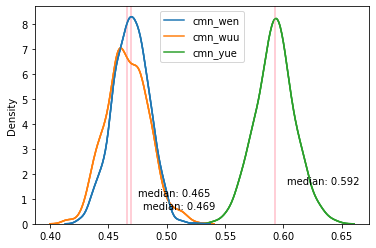

In [35]:
plot(all_cmn_df)

From their mean and median, we can see wuu and wen pair has considerately smaller values than wuu and wen with yue. On the other hand, wuu and yue shows stronger difference than wen and yue (interesting!)

Language pair: wuu, wen
mean:  0.5229343993868066 ; median:  0.5229440512122197 standard derivation:  0.017535919975951542
2u:  0.48787221126031655 - 0.5580158911641228
Language pair: wuu, yue
mean:  0.6471938717395043 ; median:  0.647680943790242 standard derivation:  0.0162121064323238
2u:  0.6152567309255944 - 0.6801051566548896
Language pair: wen, yue
mean:  0.6273922243267153 ; median:  0.6275842721704645 standard derivation:  0.015546682811917097
2u:  0.5964909065466303 - 0.6586776377942988


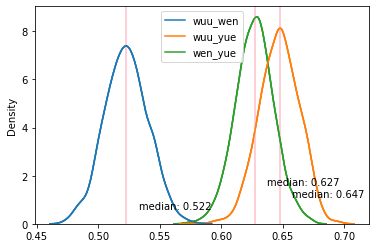

In [36]:
stack = np.stack((np.array(sample_ww),np.array(sample_wuy), np.array(sample_wey)), axis=1)
all_cmn_df = pd.DataFrame(stack, columns=["wuu_wen", "wuu_yue", "wen_yue"])
plot(all_cmn_df)